从头开始基于循环神经⽹络实现字符级语⾔模型。这样的模型将在H.G.Wells的时光机器数据集上训练。

In [2]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 读取数据集
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


## 独热编码
在train_iter中，每个词元都表⽰为⼀个数字索引，将这些索引直接输⼊神经⽹络可能会使学习变
得困难。我们通常将每个词元表⽰为更具表现⼒的特征向量。最简单的表⽰称为独热编码（one-hot encoding）。
简⾔之，将每个索引映射为相互不同的单位向量：假设词表中不同词元的数⽬为N（即len(vocab)），词元索
引的范围为0到N − 1。如果词元的索引是整数i，那么我们将创建⼀个⻓度为N的全0向量，并将第i处的元素
设置为1。此向量是原始词元的⼀个独热向量。索引为0和2的独热向量如下所⽰：



In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

每次采样的⼩批量数据形状是⼆维张量：（批量⼤⼩，时间步数）。one_hot函数将这样⼀个⼩批量数据转
换成三维张量，张量的最后⼀个维度等于词表⼤⼩（len(vocab)）。我们经常转换输⼊的维度，以便获得形状
为（时间步数，批量⼤⼩，词表⼤⼩）的输出。这将使我们能够更⽅便地通过最外层的维度，⼀步⼀步地更
新⼩批量数据的隐状态。


In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape


torch.Size([5, 2, 28])

## 初始化模型参数
接下来，初始化循环神经⽹络模型的模型参数。隐藏单元数num_hiddens是⼀个可调的超参数。当训练语
⾔模型时，输⼊和输出来⾃相同的词表。因此，它们具有相同的维度，即词表的⼤⼩。


In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 循环神经网络模型
为了定义循环神经⽹络模型，我们⾸先需要⼀个init_rnn_state函数在初始化时返回隐状态。这个函数的返
回是⼀个张量，张量全⽤0填充，形状为（批量⼤⼩，隐藏单元数）。在后⾯的章节中我们将会遇到隐状态包
含多个变量的情况，⽽使⽤元组可以更容易地处理些。


In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

下⾯的rnn函数定义了如何在⼀个时间步内计算隐状态和输出。循环神经⽹络模型通过inputs最外层的维度
实现循环，以便逐时间步更新⼩批量数据的隐状态H。此外，这⾥使⽤tanh函数作为激活函数。如之前所述，
当元素在实数上满⾜均匀分布时，tanh函数的平均值为0。


In [7]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量⼤⼩，词表⼤⼩)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    
    # X的形状：(批量⼤⼩，词表⼤⼩)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们创建⼀个类来包装这些函数，并存储从零开始实现的循环神经⽹络
模型的参数。


In [8]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经⽹络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)


检查输出是否具有正确的形状。例如，隐状态的维数是否保持不变。

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                        init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)

Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是（时间步数×批量⼤⼩，词表⼤⼩），⽽隐状态形状保持不变，即（批量⼤⼩，隐藏
单元数）。

## 预测
⾸先定义预测函数来⽣成prefix之后的新字符，其中的prefix是⼀个⽤⼾提供的包含多个字符的字符
串。在循环遍历prefix中的开始字符时，我们不断地将隐状态传递到下⼀个时间步，但是不⽣成任何输出。这
被称为预热（warm-up）期，因为在此期间模型会⾃我更新（例如，更新隐状态），但不会进⾏预测。预热期
结束后，隐状态的值通常⽐刚开始的初始值更适合预测，从⽽预测字符并输出它们。

In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device): #@save
    """在prefix后⾯⽣成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


可以测试predict_ch8函数。我们将前缀指定为time traveller，并基于这个前缀⽣成10个后续字
符。鉴于我们还没有训练⽹络，它会⽣成荒谬的预测结果。


In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller arngtczldp'

## 梯度裁剪
对于⻓度为T的序列，我们在迭代中计算这T个时间步上的梯度，将会在反向传播过程中产⽣⻓度为O(T)的
矩阵乘法链。如 4.8节所述，当T较⼤时，它可能导致数值不稳定，例如可能导致梯度爆炸或梯度消失。因此，
循环神经⽹络模型往往需要额外的⽅式来⽀持稳定训练。

⼀般来说，当解决优化问题时，我们对模型参数采⽤更新步骤。假定在向量形式的x中，或者在⼩批量数据的
负梯度g⽅向上。例如，使⽤η > 0作为学习率时，在⼀次迭代中，我们将x更新为x − ηg。如果我们进⼀步假
设⽬标函数f表现良好，即函数f在常数L下是利普希茨连续的（Lipschitz continuous）。也就是说，对于任
意x和y我们有：  

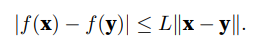  

在这种情况下，我们可以安全地假设：如果我们通过ηg更新参数向量，则  

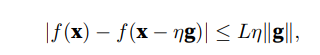  

这意味着我们不会观察到超过Lη∥g∥的变化。这既是坏事也是好事。坏的⽅⾯，它限制了取得进展的速度；好
的⽅⾯，它限制了事情变糟的程度，尤其当我们朝着错误的⽅向前进时。

有时梯度可能很⼤，从⽽优化算法可能⽆法收敛。我们可以通过降低η的学习率来解决这个问题。但是如果
我们很少得到⼤的梯度呢？在这种情况下，这种做法似乎毫⽆道理。⼀个流⾏的替代⽅案是通过将梯度g投
影回给定半径（例如θ）的球来裁剪梯度g。如下式：  
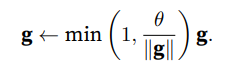  

通过这样做，我们知道梯度范数永远不会超过θ，并且更新后的梯度完全与g的原始⽅向对⻬。它还有⼀个值
得拥有的副作⽤，即限制任何给定的⼩批量数据（以及其中任何给定的样本）对参数向量的影响，这赋予了
模型⼀定程度的稳定性。梯度裁剪提供了⼀个快速修复梯度爆炸的⽅法，虽然它并不能完全解决问题，但它
是众多有效的技术之⼀。

下⾯我们定义⼀个函数来裁剪模型的梯度，模型是从零开始实现的模型或由⾼级API构建的模型。我们在此
计算了所有模型参数的梯度的范数。

In [12]:
def grad_clipping(net, theta): #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练
在训练模型之前，让我们定义⼀个函数在⼀个迭代周期内训练模型。它与我们训练 3.6节模型的⽅式有三个
不同之处。
* 序列数据的不同采样⽅法（随机采样和顺序分区）将导致隐状态初始化的差异。
* 我们在更新模型参数之前裁剪梯度。这样的操作的⽬的是，即使训练过程中某个点上发⽣了梯度爆炸，也能保证模型不会发散。
* 我们⽤困惑度来评价模型。如之前所述，这样的度量确保了不同⻓度的序列具有可⽐性。

具体来说，当使⽤顺序分区时，我们只在每个迭代周期的开始位置初始化隐状态。由于下⼀个⼩批量数据中
的第i个⼦序列样本与当前第i个⼦序列样本相邻，因此当前⼩批量数据最后⼀个样本的隐状态，将⽤于初始
化下⼀个⼩批量数据第⼀个样本的隐状态。这样，存储在隐状态中的序列的历史信息可以在⼀个迭代周期内
流经相邻的⼦序列。然⽽，在任何⼀点隐状态的计算，都依赖于同⼀迭代周期中前⾯所有的⼩批量数据，这
使得梯度计算变得复杂。为了降低计算量，在处理任何⼀个⼩批量数据之前，我们先分离梯度，使得隐状态
的梯度计算总是限制在⼀个⼩批量数据的时间步内。

当使⽤随机抽样时，因为每个样本都是在⼀个随机位置抽样的，因此需要为每个迭代周期重新初始化隐状
态。与 3.6节中的 train_epoch_ch3函数相同，updater是更新模型参数的常⽤函数。它既可以是从头开始实
现的d2l.sgd函数，也可以是深度学习框架中内置的优化函数。


In [13]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练⽹络⼀个迭代周期（定义⻅第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第⼀次迭代或使⽤随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调⽤了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经⽹络模型的训练函数既⽀持从零开始实现，也可以使⽤⾼级API来实现。


In [14]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
            use_random_iter=False):
    """训练模型（定义⻅第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


现在，我们训练循环神经⽹络模型。因为我们在数据集中只使⽤了10000个词元，所以模型需要更多的迭代周
期来更好地收敛。


困惑度 1.0, 86075.4 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


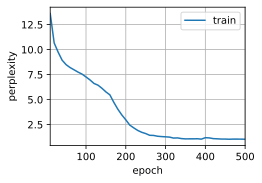

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查⼀下使⽤随机抽样⽅法的结果。

困惑度 1.5, 86911.9 词元/秒 cuda:0
time traveller hal sodin efimsions are passing along the time di
traveller for so it will be convenient to speak of himwas e


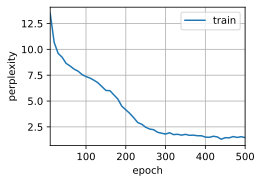

In [16]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)


从零开始实现上述循环神经⽹络模型，虽然有指导意义，但是并不⽅便。在下⼀节中，我们将学习如何改进
循环神经⽹络模型。例如，如何使其实现地更容易，且运⾏速度更快。

## 小结
* 我们可以训练⼀个基于循环神经⽹络的字符级语⾔模型，根据⽤⼾提供的⽂本的前缀⽣成后续⽂本。
* ⼀个简单的循环神经⽹络语⾔模型包括输⼊编码、循环神经⽹络模型和输出⽣成。
* 循环神经⽹络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使⽤初始化⽅法不同。
* 当使⽤顺序划分时，我们需要分离梯度以减少计算量。
* 在进⾏任何预测之前，模型通过预热期进⾏⾃我更新（例如，获得⽐初始值更好的隐状态）。
* 梯度裁剪可以防⽌梯度爆炸，但不能应对梯度消失。